# Potts Model example

### MSA

`0   1   2
 A   B   B
 A   C   B
 C   C   A
 A   C   B`

In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
MSA = np.array([
    ['A', 'B', 'B'],
    ['A', 'C', 'B'],
    ['C', 'C', 'A'],
    ['A', 'C', 'B']
],dtype='O')

$$f_i(k) = \frac{1}{B} \sum_{b=1}^B \delta(\sigma_i^{(b)}, k)$$

In [3]:
fi_k = torch.empty((3, 3))

B = len(MSA)

for i in range(3):
    for j, a in enumerate(['A', 'B', 'C']):
        fi_k[i, j] = 1/B * np.sum(MSA[:, i] == a)

In [4]:
fi_k

tensor([[0.7500, 0.0000, 0.2500],
        [0.0000, 0.2500, 0.7500],
        [0.2500, 0.7500, 0.0000]])

$$f_{i,j}(k,l) = \frac{1}{B} \sum_{b=1}^B \delta(\sigma_i^{(b)}, k)\delta(\sigma_j^{(b)}, l)$$

In [5]:
fij_kl = torch.empty((3, 3, 3, 3))

for i in range(3):
    for j in range(3):
        for k, ai in enumerate(['A', 'B', 'C']):
            for l, aj in enumerate(['A', 'B', 'C']):
                fij_kl[i, j, k, l] = 1 / B * np.sum((1 * (MSA[:, i] == ai)) * (1 * (MSA[:, j] == aj)))

In [6]:
fij_kl

tensor([[[[0.7500, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.2500]],

         [[0.0000, 0.2500, 0.5000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.2500]],

         [[0.0000, 0.7500, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.2500, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000],
          [0.2500, 0.0000, 0.0000],
          [0.5000, 0.0000, 0.2500]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.2500, 0.0000],
          [0.0000, 0.0000, 0.7500]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.2500, 0.0000],
          [0.2500, 0.5000, 0.0000]]],


        [[[0.0000, 0.0000, 0.2500],
          [0.7500, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.2500],
          [0.0000, 0.2500, 0.5000],
          [0.0000, 0.0000, 0.0000]],

         [[0.2500, 0.0000, 0.0000],
          [0.0000, 0.7500, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])

# Potts Model

is a model that calculates the probability of a sequence, while satisfying two constraints (if we could consider all possible sequences, than the propensity of each symbol at each position would be $f_ij$ and the connected correlations would be $f_{i,j}(k, l)$):

$$P(\sigma_i = k) = \sum_{\substack{\mathbf{\sigma} \\ \sigma_i = k}} P(\mathbf{\sigma}) = f_i(k)$$

$$P(\sigma_i = k, \sigma_j = l) = \sum_{\substack{\mathbf{\sigma} \\ \sigma_i = k \\ \sigma_j = l}} P(\mathbf{\sigma}) = f_{i, j}(k, l)$$

A model that satisfies this is:

$$P(\sigma) = \frac{1}{Z} exp\left( \sum_{i=1}^N h_i(\sigma_i) + \sum_{i = 1}^{N - 1} \sum_{j = i + 1} ^ N J_{i, j} (\sigma_i, \sigma_j)\right)$$

where $Z$ is the partition function, that normalizes the distribution (ensures that the probabilities sum to 1)

In [7]:
def potts(seq, h, J, Z=torch.tensor(1), alphabet=None):
    '''
    Calculates the probability of a sequence given parameters "h" and "J"
    '''
    if alphabet is None:
        alphabet = dict(zip([i for i in 'ABCDEFGHIJKLMNOPRQSTUWVXYZ'], range(26)))
    
    # h part
    hsum = 0
    for i in range(len(seq)):
        hsum += h[i, alphabet[seq[i]]]
    
    # J part
    jsum = 0
    
    for i in range(len(seq) - 1):
        for j in range(i + 1, len(seq)):
            jsum += J[i, j, alphabet[seq[i]], alphabet[seq[j]]]
            
    return (1 / Z * torch.exp(hsum + jsum)).item()

### Calculate the value of Partition Function

In [8]:
seqlist = []
for i in ['A', 'B', 'C']:
    for j in ['A', 'B', 'C']:
        for k in ['A', 'B', 'C']:
            seqlist.append(i+j+k)

In [9]:
Z = 0
for s in seqlist:
    Z += potts(s, fi_k, fij_kl)

In [10]:
Z

178.40069270133972

## Sequence probabilities

In [11]:
sp = np.empty((27, 2), dtype='O')

for i, s in enumerate(seqlist):
    sp[i] = [s, potts(s, fi_k, fij_kl, Z)]

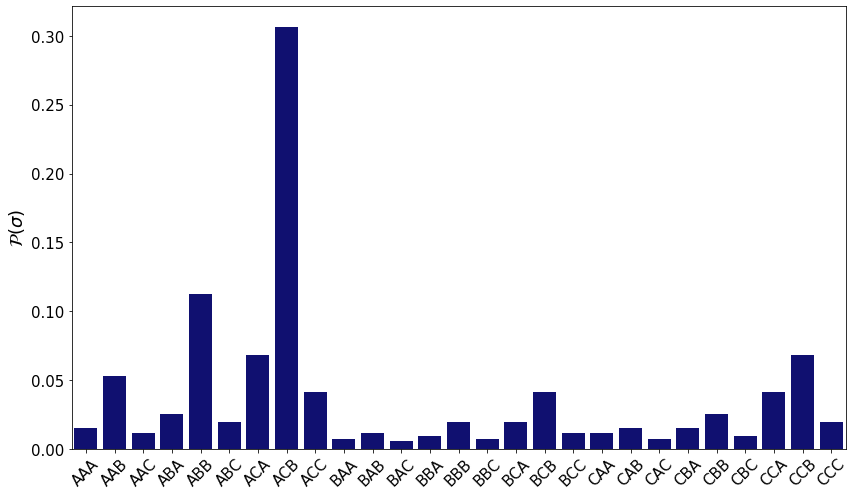

In [18]:
fig = plt.figure(figsize=(12, 7))
sns.barplot(sp[:, 0], sp[:, 1], palette=['navy' for i in range(27)])
plt.ylabel(r'$\mathcal{P}(\sigma)$', fontsize=18)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('../plots/potts_example.png')

# Finding the parameters of the Potts Model

### 1. C) The inverse Potts Problem

In [98]:
def loss(h, J, fi_k, fij_kl, Z):  
    return torch.log(Z) - torch.sum(h * fi_k) - torch.sum(J * fij_kl)

initialize parameters `h` and `J`

In [105]:
h = torch.rand((3, 3), requires_grad=True)
J = torch.rand((3, 3, 3, 3))
J = (0.5 * (J + J.permute((1, 0, 3, 2)))).requires_grad_()

Find minimum

In [106]:
alpha = 0.1
for i in range(1000):
    if h.grad is not None:
        h.grad.zero_()
    if J.grad is not None:
        J.grad.zero_()
    
    L = loss(h, J, fi_k, fij_kl, torch.tensor(Z))
    L.backward()
    
    h = (h - alpha * h.grad).detach().requires_grad_()
    J = J - alpha * J.grad
    J = (0.5 * (J + J.permute((1, 0, 3, 2)))).detach().requires_grad_()
    if i % 100 == 0:
        with torch.no_grad():
            L = loss(h, J, fi_k, fij_kl, torch.tensor(Z))
            print(L)

tensor(-2.2191)
tensor(-67.2191)
tensor(-132.2190)
tensor(-197.2195)
tensor(-262.2197)
tensor(-327.2198)
tensor(-392.2200)
tensor(-457.2201)
tensor(-522.2203)
tensor(-587.2192)


In [107]:
h.detach_()
J.detach_()
print()

In [108]:
h = h / torch.sum(h, dim=1)
np.round(h.data.numpy(), 3)

array([[0.74 , 0.008, 0.254],
       [0.009, 0.247, 0.749],
       [0.249, 0.742, 0.002]], dtype=float32)

In [109]:
fi_k

tensor([[0.7500, 0.0000, 0.2500],
        [0.0000, 0.2500, 0.7500],
        [0.2500, 0.7500, 0.0000]])

In [110]:
J = J / torch.sum(J, dim=(2, 3))
np.round(J.data.numpy(), 3)

array([[[[0.731, 0.001, 0.002],
         [0.001, 0.001, 0.004],
         [0.002, 0.004, 0.246]],

        [[0.007, 0.241, 0.481],
         [0.005, 0.003, 0.007],
         [0.008, 0.004, 0.244]],

        [[0.009, 0.718, 0.003],
         [0.005, 0.006, 0.006],
         [0.241, 0.008, 0.004]]],


       [[[0.007, 0.005, 0.008],
         [0.241, 0.003, 0.004],
         [0.481, 0.007, 0.244]],

        [[0.   , 0.004, 0.005],
         [0.004, 0.243, 0.004],
         [0.005, 0.004, 0.712]],

        [[0.004, 0.002, 0.005],
         [0.005, 0.251, 0.005],
         [0.239, 0.483, 0.004]]],


       [[[0.009, 0.005, 0.241],
         [0.718, 0.006, 0.008],
         [0.003, 0.006, 0.004]],

        [[0.004, 0.005, 0.239],
         [0.002, 0.251, 0.483],
         [0.005, 0.005, 0.004]],

        [[0.251, 0.003, 0.007],
         [0.003, 0.735, 0.006],
         [0.007, 0.006, 0.006]]]], dtype=float32)

In [111]:
fij_kl

tensor([[[[0.7500, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.2500]],

         [[0.0000, 0.2500, 0.5000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.2500]],

         [[0.0000, 0.7500, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.2500, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000],
          [0.2500, 0.0000, 0.0000],
          [0.5000, 0.0000, 0.2500]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.2500, 0.0000],
          [0.0000, 0.0000, 0.7500]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.2500, 0.0000],
          [0.2500, 0.5000, 0.0000]]],


        [[[0.0000, 0.0000, 0.2500],
          [0.7500, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.2500],
          [0.0000, 0.2500, 0.5000],
          [0.0000, 0.0000, 0.0000]],

         [[0.2500, 0.0000, 0.0000],
          [0.0000, 0.7500, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])

### 2. E) Pseudolikelihood maximization

If the size of the alphabet is large, and so is the length of the sequence, then the computation of the partition function is not possible. The probability function is slightly altered.

$$
P(\sigma_{r} = \sigma_r^{(b)} | \sigma_{\setminus r} = \sigma_{\setminus r}^{(b)}) = \frac{exp \left(h_r (\sigma_r^{(b)}) + \sum_{\substack{i = 1\\i\neq r}}^L J_{ri}(\sigma_r^{(b)}, \sigma_i^{(b)})\right)}{\sum_{q \in \mathcal{A}} exp \left(h_r(q) + \sum_{\substack{i = 1\\i\neq r}}^L J_{ri}(q, \sigma_i^{(b)})\right)}$$

This asks the question:

What is the probability, that a symbol in a sequence $\sigma$ at position $r$ : $\sigma_r$ equals the symbol of the $(b)$th sequence in the MSA: $\sigma_r^{(b)}$ given that the rest of the symbols match

In [131]:
def pseudolikelihood(MSA, h, J, alphabet=None):
    """
    Calculates the pseudolikelihood of a sequence given parameters of the 
    model: 'h' and 'J' and the MSA
    """
    if alphabet is None:
        alphabet = dict(zip([i for i in 'ABC'], range(3)))
        #alphabet = dict(zip([i for i in 'ABCDEFGHIJKLMNOPRQSTUWVXYZ'], range(26)))
    
    B, N = MSA.shape
    pl = 0
    
    for r in range(N):
        for b in range(B):
            # numerator
            num = 0
            num += h[r, alphabet[MSA[b, r]]]
            for i in range(N):
                if i != r:
                    num += J[r, i, alphabet[MSA[b, r]], alphabet[MSA[b, i]]]
            
            num = torch.exp(num)
            
            # denominator
            den = 0
            for r, l in enumerate(alphabet):
                temp = 0
                temp += h[r, alphabet[l]]
                for i in range(N):
                    if i != r:
                        temp += J[r, i, alphabet[l], alphabet[MSA[b, i]]]

                den += torch.exp(temp)
            
            P = num / den
            pl += torch.log(P)
    return -1/B * pl

In [132]:
MSA

array([['A', 'B', 'B'],
       ['A', 'C', 'B'],
       ['C', 'C', 'A'],
       ['A', 'C', 'B']], dtype=object)

In [142]:
h = torch.rand((3, 3))
J = torch.rand((3, 3, 3, 3))

In [134]:
pseudolikelihood(MSA, h, J)

tensor(4.4463)

In [208]:
h = torch.rand((3, 3), requires_grad=True)
J = torch.rand((3, 3, 3, 3))
J = (0.5 * (J + J.permute((1, 0, 3, 2)))).requires_grad_()  # transpose so that values across diagonalare the same

In [209]:
alpha = 0.01
for i in range(1000):
    if h.grad is not None:
        h.grad.zero_()
    if J.grad is not None:
        J.grad.zero_()
    
    L = pseudolikelihood(MSA, h, J)
    L.backward()
    
    h = (h - alpha * h.grad).detach().requires_grad_()
    J = (J - alpha * J.grad).detach()
    J = (0.5 * (J + J.permute((1, 0, 3, 2)))).requires_grad_() # transpose J
    
    if i % 100 == 0:
        with torch.no_grad():
            L = pseudolikelihood(MSA, h, J)
            print('Iteration {:04d}, Loss: {:.3f}'.format(i, L.item()))

Iteration 0000, Loss: 4.894
Iteration 0100, Loss: -4.250
Iteration 0200, Loss: -13.135
Iteration 0300, Loss: -21.930
Iteration 0400, Loss: -30.676
Iteration 0500, Loss: -39.392
Iteration 0600, Loss: -48.088
Iteration 0700, Loss: -56.771
Iteration 0800, Loss: -65.445
Iteration 0900, Loss: -74.111


In [210]:
J.detach_()
h.detach_()
print()

In [211]:
h

tensor([[-9.7468,  0.3942,  0.5129],
        [ 0.3669, -7.3937,  0.1635],
        [ 7.5341, 17.7277, -6.4002]])

In [191]:
h = h / torch.sum(h + torch.min(h, dim=1), dim=1)
np.round(h.data.numpy(), 3)

TypeError: unsupported operand type(s) for +: 'Tensor' and 'torch.return_types.min'

In [ ]:
J = J / torch.sum(J, dim=(2, 3))
np.round(J.data.numpy(), 3)